# Interactive presentation. Press Alt-R to switch to presentation mode...

#  SPO-2016 - Provide Python interface to DP3 functions
## Team SCHAAP - Sebastiaan van der Tol
## 2022-11-23



## Objective and Key Results

Objective: Processing steps (DPSteps) from DP3 can be used in Python by commissioning scientists.

* Key result 1: DPSteps are available via a Python wrapper.

* Key result 2: The library of DPSteps is pip installable.

* Key result 3: As a use case example, a direction-independent calibration step from DP3 is demonstrated using RASCIL interfaces.

## Refactor DP3 towards streaming achitecture
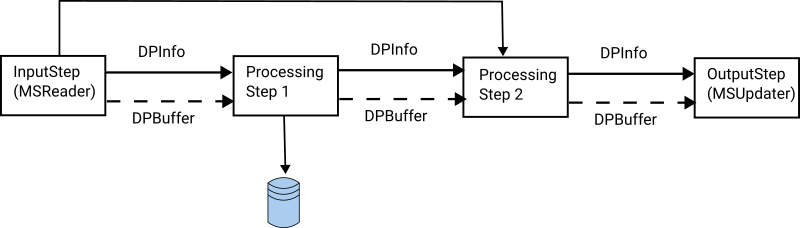

## Python Bindings

Python bindings through pybind11

Bindings work both ways:
* Use Python steps in C++ (DP3 executable)
* Use C++ steps in Python

Wrappers for
* Step
* DPInfo
* DPBuffer
* Fields
* ParameterSet
* factory function `make_step`

## RASCIL to DP3 data conversion

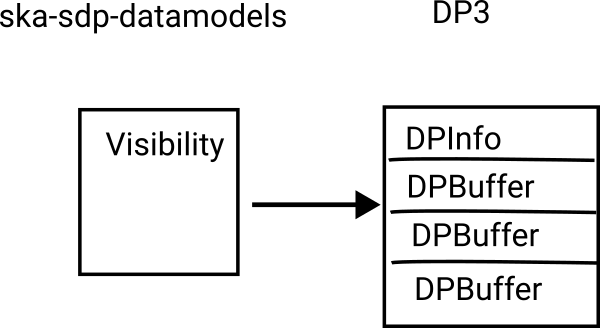

In [ ]:
!DP3 msin=tDDECal.MS msout="" steps=[gaincal] gaincal.sourcedb=tDDECal.MS/sky.txt gaincal.caltype=diagonal \
gaincal.parmdb=/home/jovyan/gaincal_solutions_dp3.h5

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import h5py
import numpy as np
f0 = h5py.File('/home/jovyan/gaincal_solutions_dp3.h5')
ampl0 = f0['sol000']['amplitude000']['val'][:].transpose((0,2,1,3))
plt.plot(ampl0[:,:,0,0]);

In [ ]:
import sys
sys.path.insert(0, "/usr/local/lib/python3.10/site-packages")
import dp3
from rascil.processing_components.visibility.base import create_visibility_from_ms

vis = create_visibility_from_ms("tDDECal.MS")[0]
parset = dp3.parameterset.ParameterSet()

parset.add("gaincal.parmdb", "/home/jovyan/gaincal_solutions.h5")
parset.add("gaincal.sourcedb", "tDDECal.MS/sky.txt")
parset.add("gaincal.caltype", "diagonal")

gaincal_step = dp3.make_step("gaincal", parset, "gaincal.", dp3.MsType.regular)
null_step = dp3.make_step("null", parset, "", dp3.MsType.regular)
gaincal_step.set_next_step(null_step)
nr_correlations = vis.polarisation.size

dpinfo = dp3.DPInfo(nr_correlations)

dpinfo.set_channels(vis.frequency.data, vis.channel_bandwidth.data)
print("frequencies: ", dpinfo.channel_frequencies)
print("widths: ", dpinfo.channel_widths)


In [ ]:
antenna1 = vis.antenna1.data
antenna2 = vis.antenna2.data
antenna_names = vis.configuration.names.data
antenna_positions = vis.configuration.xyz.data

antenna_diameters = vis.configuration.diameter.data
dpinfo.set_antennas(
    antenna_names,
    antenna_diameters,
    antenna_positions,
    antenna1,
    antenna2)

first_time = vis.time.data[0]
last_time = vis.time.data[-1]
time_interval = vis.integration_time.data[0]
dpinfo.set_times(first_time, last_time, time_interval)    

dpinfo.phase_center = [vis.phasecentre.ra.rad, vis.phasecentre.dec.rad]

gaincal_step.set_info(dpinfo)

In [ ]:
print(gaincal_step)

In [ ]:
for time, vis_per_timeslot in vis.groupby('time'):
    dpbuffer = dp3.DPBuffer()
    dpbuffer.set_time(time)    
    dpbuffer.set_data(vis_per_timeslot.vis.data.astype(np.complex64))
    dpbuffer.set_uvw(-vis_per_timeslot.uvw.data)     
    dpbuffer.set_flags(vis_per_timeslot.flags.data.astype(bool))
    dpbuffer.set_weights(vis_per_timeslot.weight.data.astype(np.float32)) 
    gaincal_step.process(dpbuffer)

gaincal_step.finish()


In [ ]:
f1 = h5py.File('/home/jovyan/gaincal_solutions.h5')
ampl1 = f1['sol000']['amplitude000']['val'][:].transpose((0,2,1,3))
plt.plot(ampl0[:,:,0,0])
plt.gca().set_prop_cycle(None)
plt.plot(ampl1[:,:,0,0],'.');


## Notable differences between RASCIL and DP3
* Times axis, Visibility contains multiple (entire MS?) timeslots, DPBuffer only one
* Minus sign UVW coordinates
* MSReader fills weight from WEIGHT_SPECTRUM column, create_visibility_from_ms reads WEIGHT and then expands along frequency axis

## Conclusions & Outlook

* DP3 steps can be used from Python
* This allows to use them in a RASCIL workflow
* Not all steps are available yet
* DP3 gain tables still go to disk first